## Time Series Forecasting

A survey of statistical and deep learning models

## What's a time series

A set of observations at regular time steps

In [1]:
from IPython.display import IFrame

# Source: https://data.gov.sg/dataset/hdb-resale-price-index
print("HDB Resale Price Index (Univariate)")
IFrame('https://data.gov.sg/dataset/hdb-resale-price-index/resource/52e93430-01b7-4de0-80df-bc83d0afed40/view/14c47d07-1395-4661-8466-728abce27f5f', width=600, height=400)

HDB Resale Price Index (Univariate)


In [2]:
from IPython.display import IFrame

# Source: https://data.gov.sg/dataset/average-weekly-paid-hours-worked-per-employee-by-industry-and-type-of-employment-annual
print("Annual Average Weekly Paid Hours Worked Per Employee, By Industry And Type Of Employment (Multi-variate)")
IFrame('https://data.gov.sg/dataset/average-weekly-paid-hours-worked-per-employee-by-industry-and-type-of-employment-annual/resource/dd2147ce-20b7-401c-ac8f-8dbcc0d8e0d9/view/431f44b1-e58d-4131-998d-7e7aeee14479', width='600', height='400')

Annual Average Weekly Paid Hours Worked Per Employee, By Industry And Type Of Employment (Multi-variate)


## Time Series Decomposition

- For analysis
- Split into trend, cyclic, seasonal, noise
- Multiplicative or additive

## Walkthrough: Time Series Decomposition
1. Go to https://data.gov.sg/dataset/hdb-resale-price-index
2. Click on the `Download` button
3. Unzip and extract the `.csv` file. Note that path to that file for use later.


We will use the [StatsModels](https://www.statsmodels.org/stable/index.html) Python library to perform the decomposition. 

This library will also be used later to perform statistical analysis. [Pandas](https://pandas.pydata.org/pandas-docs/stable/timeseries.html) is also useful for manipulating time series data.

In [ ]:
"""Walkthrough: Time Series Decomposition"""

#!pip install statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot as plt
import pandas as pd

# ==================================================================
# Dataset URL: https://data.gov.sg/dataset/hdb-resale-price-index
#
# Update this path to match your actual path
data_path = 'D:\\tmp\\hdb-resale-price-index\\housing-and-development-board-resale-price-index-1q2009-100-quarterly.csv'

# load data
df = pd.read_csv(data_path, index_col=0,
                 parse_dates=True, infer_datetime_format=True)

# print first few rows to make sure we loaded it properly
df.head(5)

### DateTimeIndex

From the table above, we can confirm it is indeed a quarterly distribution. 

`seasonal_decompose` ([docs](http://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html)) expects a DateTimeIndex to indicate the frequency of the time series. 

To enable this, we've set `parse_dates=True` and `index_col=0` so that the `DataFrame.index` property is correctly set as a `pandas.DatetimeIndex` ([docs](https://pandas.pydata.org/pandas-docs/stable/timeseries.html#generating-ranges-of-timestamps)), with a quarterly frequency.

In [ ]:
# print the index.
# note that this is different from the "index" column in the DataFrame,
# which refers to the Resale Price Index.
print(df.index)

In [ ]:
# plot the raw data, how that we have a DatetimeIndex
ax = df.plot()

## Additive vs. Multiplicative Decomposition

Now we are ready to decompose.  Let's try two models: `additive` and `multiplicative`.

You can find the definitions in the [StatsModels documentation](http://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html), but in a nutshell, the `additive` model "adds up" the components, while the `multiplicative` model "multiplies" the components together.

Additive: $$y(t) = Trend + Seasonal + Residual$$

Mulplicative: $$y(t) = Trend * Seasonal * Residual$$

In [ ]:
# it's a bit confusing, but `index` here refers to the HDB resale price index,
# not the DataFrame.index (for time series)
additive = seasonal_decompose(df, model='additive')
additive.plot()
plt.show()

In [ ]:
multiplicative = seasonal_decompose(df, model='multiplicative')
multiplicative.plot()
plt.show()

## Observations

- There is a strong seasonal component. The component values are available as part of the object returned by `seasonal_decompose`
- The multiplicative model seems like a better fit, because the resulting residuals are smaller. In general, residuals (noise) are difficult to fit statistically.

## Why decompose?
- The purpose of decomposition is to "subtract" known variability and simpilify creating models. For example, we can ignore the seasonal component and focus on predicting the trend.
- `series_decompose` uses a naive implementation. For a more advanced decomposition library, see [STLDecompose]( https://github.com/jrmontag/STLDecompose/blob/master/STL%20usage%20example.ipynb)

In [ ]:
# print out the first few elements of each seasonal component
print('Multiplicative model: Seasonal component')
print(multiplicative.seasonal[:10])

print('Multiplicative model: Trend component')
print(multiplicative.trend[:10])

print('Additive model: Seasonal component')
print(additive.seasonal[:10])

print('Additive model: Trend component')
print(additive.trend[:10])

## Forecasting

- Statistical: Auto-regressive, Moving average models

- Deep Learning: LSTMs

## Auto-regressive models

$AR(p): X_t=c + \sum_{i=1}^p \varphi_iX_{t-i} + \varepsilon_t$

Output ($X_t$) depends on past values ($X_{t-i}$) + white noise ($\varepsilon_t$)

## Fitting auto-regressive models

1. Use Autocorrelation to pick parameter $p$, which indicates how far back in time $X_{t-i}$ should go
2. Train model to fit data, minimizing mean squared error

## Workshop: Auto-regression

In this workshop, we'll take the dataset we've been working with and see if we can train an auto-regressive model for it.

Credits: borrowed heavily from https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/

In [ ]:
"""Workshop: Auto-regression"""

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

# ==================================================================
# Dataset URL: https://data.gov.sg/dataset/hdb-resale-price-index
#
# Update this path to match your actual path
data_path = 'D:\\tmp\\hdb-resale-price-index\\housing-and-development-board-resale-price-index-1q2009-100-quarterly.csv'

# load data
df = pd.read_csv(data_path, index_col=0,
                 parse_dates=True, infer_datetime_format=True)

# print first few rows to make sure we loaded it properly
df.head(5)

## Lag plots

A quick first test is to check if the data is random. If random, the data will not exhibit a structure in the lag plot.

Let's try [`pandas.plotting.lag_plot`](https://pandas.pydata.org/pandas-docs/stable/visualization.html#lag-plot).

In [ ]:
# try to see if there are correlations between X(t) and X(t-1)

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20,10))
df.plot(ax=ax1) # series plot
pd.plotting.lag_plot(df['index']) # lag plot

As a comparison, here's what the lag plot will look like for a random series:

In [ ]:
# generate a random series
random_df = pd.DataFrame(np.random.randint(0, 100, size=(100, 1)))

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20,10))
random_df.plot(ax=ax1) # series plot
pd.plotting.lag_plot(random_df, ax=ax2) # lag plot (shows no correlation!)

So, it does look like there is correlation with the current and previous value of the HDB resale price index.

We are ready to move to the next step.

## Auto-correlation plots
The next test is use auto-correlation to pick a good value of `p` to use for the equation:

$AR(p): X_t=c + \sum_{i=1}^p \varphi_iX_{t-i} + \varepsilon_t$

We will use the `pandas.plotting.autocorrelation_plot`: https://pandas.pydata.org/pandas-docs/stable/visualization.html#autocorrelation-plot

In [ ]:
pd.plotting.autocorrelation_plot(df['index'])

Again, it is helpful to compare with a random series:

In [ ]:
pd.plotting.autocorrelation_plot(random_df)

## Interpreting Auto-correlation plots

The [docs](https://pandas.pydata.org/pandas-docs/stable/visualization.html#autocorrelation-plot) have a good explanation that we'll summarize here:

- Auto-correlation plots show the auto-correlation at different time lags (`p`)
- Random time series: the auto-correlations always hover around zero
- Non-random time series: find values of Lag where auto-correlations are outside of the 95% or 99% confidence band.
  - 95%: solid line
  - 99%: dashed line
- Both negative and positive auto-correlations are valid

## Auto-regressive model

Since the dataset is about HDB quarterly resale prices, we can develop a model to predict the resale prices for the next year (4 quarters).

Recall that an Auto-regessive model uses the past values to predict the next value in the series:

$$AR(p): X_t=c + \sum_{i=1}^p \varphi_iX_{t-i} + \varepsilon_t$$

## Baseline model

Before we fit the AR model, it's a good idea to create a baseline model.

The simplest possible one is a "Persistence Model", which just predicts the current value based on the last observation.

$$X_t = X_{t-1}$$

### Predictions using a Persistence Model
1. The time series is a vector of (t, X) values. To model it, we will time-shift the dataset to produce two vectors (x, y).
    - input: $x = X_t$
    - output: $y = X_{t+1}$
2. We'll then split the (x, y) dataset into train and test
3. Run the baseline model to get predictions:
$$\hat{y} = BaselineModel(x)$$ Where: $$BaselineModel(x) = x$$

4. Then compute the means square error:
$$score = MSE(y, \hat{y})$$

In [ ]:
def create_lagged_dataset(data):
    """Creates the dataset used for time-series modeling
    Args:
        data: the time series data (X)
    Returns:
        the lagged dataset (X[t], X[t+1]) as a pandas.DataFrame
    """
    values = pd.DataFrame(data)
    df = pd.concat([values.shift(1), values], axis=1) # concat in the column axis
    df.columns = ['t', 't+1']
    return df
    
def split_train_test(data, split_percent=10):
    """Splits the dataset into train and test sets
    Note that for time series data, we should not use random split
    because sequence is important.
    We'll just split by taking the last split_percent values
    
    Args:
        data: the dataset (x, y)
        split_percent: the percentage of the dataset to reserve
                       for testing
    Returns:
        tuple: (train, test) as pandas.DataFrames
    """
    split_index = int(((1-split_percent)/100) * data.shape[0])
    
    x = data.values
    train, test = x[1:split_index], x[split_index:]
    
    train_df = pd.DataFrame.from_records(train, columns=['x', 'y'])
    test_df = pd.DataFrame.from_records(test, columns=['x', 'y'])

    return train_df, test_df

def baseline_model(x):
    """Baseline model which gives the provided value
    It implements: f(x) = x
    Args:
        x: the value
    Returns:
        the provided value
    """
    return x

In [ ]:
from sklearn.metrics import mean_squared_error

# create datasets
dataset = create_lagged_dataset(df['index'])
print("\nDataset:\n", dataset.head(5))

train, test = split_train_test(dataset)
print("\nTrain:\n", train.head(5))
print("\nTest:\n", test.head(5))

# walk-forward validation using baseline model: f(x) = x
baseline_predictions = [baseline_model(x) for x in test['x']]

# plot the predictions vs truth
_, ax = plt.subplots(figsize=(20,10))
f1, = ax.plot(test['y'])
f2, = ax.plot(baseline_predictions, color='red')
ax.legend([f1, f2], ['truth', 'baseline prediction'])
plt.show()

score = mean_squared_error(test['y'], baseline_predictions)
print("MSE:", score)

## Auto-regression model

Now that we have our baseline model in place, we can proceed with Auto-regression.

We'll use the [`statsmodels.tsa.ar_model.AR`](http://www.statsmodels.org/devel/generated/statsmodels.tsa.ar_model.AR.html)

Unlike the baseline model where we have to create a lagged time series, the AR model takes in a time series directly.

In [ ]:
def split_train_test_timeseries(timeseries, split_percent=10):
    """Splits a time series DataFrame into train and test sets
    Note that for time series data, we should not use random split
    because sequence is important.
    We'll just split by taking the last split_percent values
    
    Args:
        timeseries: the time series DataFrame (index=date_time, X)
        split_percent: the percentage of the time series to reserve
                       for testing
    Returns:
        tuple: (train, test) as pandas.DataFrames
    """
    split_index = int(((1-split_percent)/100) * timeseries.shape[0])
    
    train = timeseries.iloc[:split_index, :]
    test = timeseries.iloc[split_index:, :]
    
    return train, test

In [ ]:
from statsmodels.tsa.ar_model import AR

# create the Auto-regression model using the training set
train_ts, test_ts = split_train_test_timeseries(df)
print("\nTrain:\n", train_ts.head(5))
print("\nTest:\n", test_ts.head(5))

model = AR(train_ts)

# fit the model
%time ar_model = model.fit()

print('Best lag: %s' % ar_model.k_ar)
print('Coefficients: %s' % ar_model.params)

The `statsmodels.tsa.ar_model.AR` implementation picked the 12-lag model as the best one.

Next, we'll make some predictions using the AR model.

In [ ]:
test_start = pd.to_datetime(test_ts.index.values[0])
print("Start date", test_start)
test_end = pd.to_datetime(test_ts.index.values[-1])
print("End date", test_end)

ar_predictions = ar_model.predict(start=test_start, end=test_end)
baseline_predictions_ts = pd.DataFrame({'index': baseline_predictions}, index=ar_predictions.index)

# plot the predictions vs truth
_, ax = plt.subplots(figsize=(20,10))
f3, = ax.plot(test_ts)
f4, = ax.plot(ar_predictions, color='red')
f5, = ax.plot(baseline_predictions_ts, color='black')
ax.legend([f3, f4, f5], ['truth', 'AR(12) prediction', 'baseline prediction'])
plt.show()

score_ts = mean_squared_error(test_ts, ar_predictions)
print("MSE (AR 12):", score_ts)
print("MSE (baseline):", score)

## What happened?

The AR fitted model performed MUCH WORSE than the baseline model.

Can you think of reasons to explain this?

Hint: look at the series, and think about what we are trying to predict here. 

## Try Decomposition?

Let's see if decomposition can help us fit a better model.

We'll use the Multiplicative model, because it appears to result in a smaller random component.

In [ ]:
# ==================================================================
# Exercise:
# 1. Use multiplicative decomposition to extract the trend
#    Hint: You'll need to drop the first 2 NaN values using iloc
#    Otherwise, you'll get "LinAlgError: SVD did not converge"
#
#       df_trend = multiplicative.trend.dropna()
#












# 2. Re-train the AR model
#    Hint: use split_train_test_timeseries like above.












# 3. Compare the performance with the other models
#    Hint: you should plot 4 lines
#            truth
#            baseline
#            AR on original series
#            AR on multiplicative trend (new model)
#          you should also compute the MSE for predictions from the new model
#















## Moving Average Model

We spent some time looking and trying out an Auto-regressive (AR) model. 

Next: Moving Average (MA) model, and the combination of both.

## Moving Average Model

$MA(p): X_t=\mu + \varepsilon_t + \sum_{i=1}^p\theta_i\varepsilon_{t-i}$

Output hovers around an average ($\mu$) and depends on past $p$ values of white noise ($\varepsilon_{t-i}$). 

## Auto-regressive, Moving Average Model (ARMA)

This is a combination of AR + MA:

$ARMA(p, q): AR(p) + MA(q)$

$X_t=c + \varepsilon_t + \sum_{i=1}^p \varphi_i X_{t-i} + \sum_{i=1}^q\theta_i\varepsilon_{t-i}$

## Auto-regressive, Integrated Moving Average Model (ARIMA)

$ARIMA(p, d, q): \biggl(1-\sum_{i=1}^p\varphi_iB^i\biggr)(1 - B)^dX_t = c + \biggl(1 + \sum_{i=1}^q\theta_iB^i\biggr)\varepsilon_t$

<img src='assets/time-series/short_answers_headscratch.png' style='float:right'/>

$ARIMA(p, d, q): X'_t = c + \varepsilon_t + \sum_{i=1}^p \varphi_i X'_{t-i} + \sum_{i=1}^q\theta_i\varepsilon_{t-i}$

$ARMA(p, d, q): X_t=c + \varepsilon_t + \sum_{i=1}^p \varphi_i X_{t-i} + \sum_{i=1}^q\theta_i\varepsilon_{t-i}$

$X'_t$ = $X_t$, Differentiated $d$ times

$X_t$ = $X'_t$, Integrated $d$ times (hence the _I_ in ARIMA)

Think of ARIMA as something like:

1. $X' = Differential(X, degree=d)$
2. $X'_t = ARMA(X')$
3. $X_t = Integral(X'_t)$

## Stationary Time Series

Mean, variance don't change over time (i.e. time-invariant)

Easier to model

Differentiation transforms a time series to become **Stationary**

## Walkthrough: Time Series Stationarity

In this walkthrough, we will look at examples of stationary vs. non-stationary time series.

We'll also try modeling a non-stationary series using the ARIMA algorithm to see the effects of differentiation.

In [ ]:
"""Walkthrough: Time Series Stationarity"""

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

# ==================================================================
# Dataset URL: https://data.gov.sg/dataset/hdb-resale-price-index
#
# Update this path to match your actual path
data_path = 'D:\\tmp\\hdb-resale-price-index\\housing-and-development-board-resale-price-index-1q2009-100-quarterly.csv'

# load data
df = pd.read_csv(data_path, index_col=0,
                 parse_dates=True, infer_datetime_format=True)

# Plot a histogram of the observations
df.hist()

From the above histogram, this suggests a non-stationary series, where the mean and variance changes over time.

Let's plot histograms of the components.

In [ ]:
multiplicative = seasonal_decompose(df, model='multiplicative')

# The seasonal component hovers around 3 values
multiplicative.seasonal.hist()

In [ ]:
# The noise component is fairly gaussian
multiplicative.resid.hist()

In [ ]:
# The trend follows the same pattern as the series
multiplicative.trend.hist()

## ARMA vs. ARIMA

Since the trend looks fairly non-stationary, let's explore predictions from both the Auto-regressive Moving Average (ARMA) and the Auto-regressive Integrated Moving Average (ARIMA) models.

This should also tell us if differentiation makes any difference in finding a stationary series that we can model.

## ARMA: selecting best order

We will use Akaike's Information Criterion (AIC) and the Bayesian Information Criterion (BIC) to select the order.

More information about these metrics are at: www.otexts.org/fpp/8/6

In general, the smaller the better.

In [ ]:
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.stattools import arma_order_select_ic

# We'll model the multiplicative trend
mult = seasonal_decompose(df, model='multiplicative')
trend = mult.trend.dropna()

# http://www.statsmodels.org/dev/_modules/statsmodels/tsa/stattools.html#arma_order_select_ic
# 'c' means constant
train_ts, test_ts = split_train_test_timeseries(trend)
res = arma_order_select_ic(train_ts, ic=['aic', 'bic'], trend='c')
print("Order that minimizes AIC:", res.aic_min_order)
print("Order that minimizes BIC:", res.bic_min_order)

Using the order ($p = 4, q = 2$) we will now fit the ARMA model. 

In [ ]:
# fit the model
order = res.aic_min_order
model = ARMA(train_ts, order)
%time arma_model = model.fit()
print("AIC:", arma_model.aic, "BIC:", arma_model.bic)

The AIC and BIC criteria are still quite large. This means that the model may not fit very well.

Let's give it a try anyway.

In [ ]:
test_start = pd.to_datetime(test_ts.index.values[0])
test_end = pd.to_datetime(test_ts.index.values[-1])

# plot the forecast
_, ax = plt.subplots(figsize=(20, 10))
ax.plot(trend)
arma_model.plot_predict(start=test_start, end=test_end, dynamic=True, ax=ax)
plt.show()

# compute the MSE
predictions = arma_model.predict(start=test_start, end=test_end)
score = mean_squared_error(test_ts, predictions)
print("MSE (ARMA{}):".format(order), score)

The MSE is still significant, but *much* better than the AR model we looked at earlier.

Still not as good as the baseline though.

## ARIMA

Finally, let's see what ARIMA can do. We'll use [pyramid](https://github.com/tgsmith61591/pyramid), which provides an order selector for ARIMA.

In [ ]:
#!pip install pyramid-arima

from pyramid.arima import auto_arima

# auto_arima is a wrapper around R's auto.arima
# https://www.rdocumentation.org/packages/forecast/versions/7.3/topics/auto.arima
stepwise_fit = auto_arima(y=train_ts, start_p=1, start_q=1, max_p=10, max_q=10,
                          seasonal=True, max_d=5, trace=True,
                          error_action='ignore', # don't want to know if an order does not work
                          suppress_warnings=True, # don't want convergence warnings
                          stepwise=True)  # set to stepwise

stepwise_fit.summary()

The best fit appears to be with $p = 2, d = 1, q = 1$

In [ ]:
order_arima = (2, 1, 1)
model = ARIMA(train_ts, order)
%time arima_model = model.fit()
print("AIC:", arima_model.aic, "BIC:", arima_model.bic)

Better AIC and BIC than the ARMA model.

In [ ]:
test_start = pd.to_datetime(test_ts.index.values[0])
test_end = pd.to_datetime(test_ts.index.values[-1])

# plot the forecast
_, ax = plt.subplots(figsize=(20, 10))
ax.plot(trend)
arima_model.plot_predict(start=test_start, end=test_end, dynamic=True, ax=ax)
plt.show()

# compute the MSE
predictions = arima_model.predict(start=test_start, end=test_end, typ='levels')

score = mean_squared_error(test_ts, predictions)
print("MSE (ARMA{}):".format(order), score)

## Further Reading

Additional topics that are not covered, but worth reading up on:
- Vector Auto-regression (VAR) for multi-variate time series
- Partial auto-correlation plots
- Seasonal ARIMA (SARIMA)
- ARIMA with eXogeneous variables (ARIMAX)
- SARIMAX (basically a combo of the above two)

statsmodels:
- [SARIMAX](http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html),  covers SARIMA, ARIMAX, and SARIMAX
- [VAR](http://www.statsmodels.org/dev/vector_ar.html?highlight=var#module-statsmodels.tsa.vector_ar.var_model)
- [Partial Auto-correlation plots](http://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_pacf.html)

## Deep Learning models for Time Series

## Limitations of Statistical Models

- need to pick order
- sometimes won't converge
- complex to model non-linearity


## Recurrent Networks for Time Series

- LSTM unit + Fully Connected
    - Train with enough data
    - Profit!
- Stack more LSTMs for more complicated series (e.g. multi-variate)
- GRU? Why not!

## Walkthough: RNN Time Series Predictor

Dataset: Average Weekly Paid Hours Worked Per Employee By Industry And Type Of Employment, Annual

Link: https://data.gov.sg/dataset/average-weekly-paid-hours-worked-per-employee-by-industry-and-type-of-employment-annual?resource_id=ecc88c54-6d33-4d1c-9af5-896825386d56

Download, unzip, and note the path and replace it below.

Useful links:
- https://s3.amazonaws.com/assets.datacamp.com/blog_assets/PandasPythonForDataScience.pdf
- https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Python_Matplotlib_Cheat_Sheet.pdf

In [13]:
"""Walkthrough: RNN Time Series Predictor"""

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# ==================================================================
# Dataset URL: https://data.gov.sg/dataset/average-weekly-paid-hours-worked-per-employee-by-industry-and-type-of-employment-annual
#
# Update this path to match your actual path
data_path = 'D:\\tmp\\weekly-paid-hours\\average-weekly-paid-hours-worked-per-employee-by-type-of-employment-topline.csv'

# load data
df = pd.read_csv(data_path, index_col=0,
                 parse_dates=True, infer_datetime_format=True)

# Inspect
df.tail(5)

,nature_of_employment,total_paid_hours,standard_hours,overtime_paid_hours
year,,,,
2015-01-01,part-time,25.3,24.8,0.5
2016-01-01,full-time,46.4,43.0,3.4
2016-01-01,part-time,25.8,25.3,0.5
2017-01-01,full-time,46.0,42.9,3.1
2017-01-01,part-time,25.6,25.0,0.6


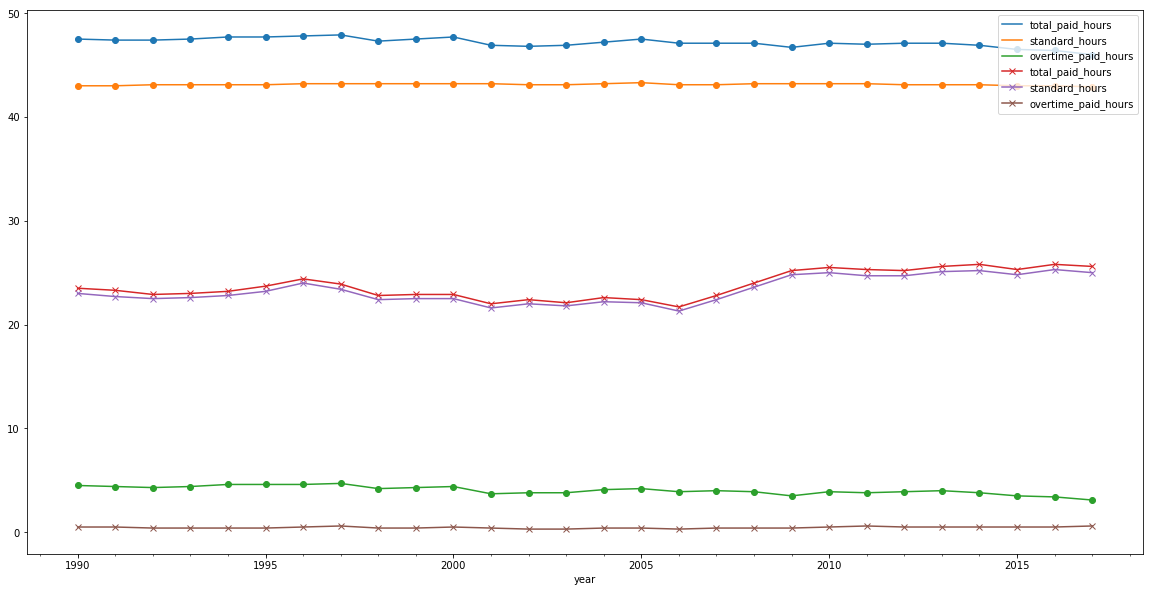

In [12]:
# let's filter by full-time vs. part-time when we plot
df_ft = df[df['nature_of_employment'] == 'full-time']
df_pt = df[df['nature_of_employment'] == 'part-time']

_, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
df_ft.plot(ax=ax, marker='o')
df_pt.plot(ax=ax, marker='x')

## Prediction Task

Let's define our prediction task.

- Task: Predict the **Full Time**, **Total Paid Hours** for **2018-2020**
- Training set: Annual data for 1990-2011
- Test set: Annual data for 2012-2016
- Model: RNN with single LSTM layer
- Baseline model: persistence model

## Baseline model

All performance is relative.  First, let's run the baseline model so that we have something to compare the performance of RNN.

In [77]:
def create_train_test(data, split_date_str):
    """Splits the dataset into train and test sets
    Note that for time series data, we should not use random split
    because sequence is important.
    We'll just split by reserving the values after the split_date
    into the test set.
    
    Args:
        data: the dataframe containing (t, X)
        split_date_str: entries after this date string will be
                        reserved in the test set. This should be
                        a string format that's acceptable by
                        pandas.to_datetime()
    Returns:
        tuple: (train, test) as pandas.DataFrames
    """
    def create_lagged_dataset(data):
        """Creates the dataset used for time-series modeling
        Args:
            data: the dataframe containing (t, X)
        Returns:
            the lagged dataset (X[t], X[t+1]) as a pandas.DataFrame
        """
        values_df = pd.DataFrame(data.values)
        df = pd.concat([values_df.shift(1), values_df],
                       axis=1) # concat in the column axis
        df.columns = ['t', 't+1']
        return df.dropna()

    # first, convert the split date into a split index
    split_date = pd.to_datetime(split_date_str)
    split_data = data[data.index <= split_date]
    split_index = split_data.shape[0]
    
    # next, create the lagged dataset (X[t], X[t+1])
    lagged_dataset = create_lagged_dataset(data['total_paid_hours'])

    # finally, split the lagged dataset using the split index
    train = lagged_dataset[:split_index]
    test = lagged_dataset[split_index:]
    return train, test

def baseline_model(x):
    """Baseline model which gives the provided value
    It implements: f(x) = x
    Args:
        x: the value
    Returns:
        the provided value
    """
    return x


Train dataset:
       t   t+1
1  47.5  47.4
2  47.4  47.4
3  47.4  47.5
4  47.5  47.7
5  47.7  47.7

Test dataset:
        t   t+1
24  47.1  46.9
25  46.9  46.5
26  46.5  46.4
27  46.4  46.0

Predictions:
 [47.1, 46.9, 46.5, 46.4]


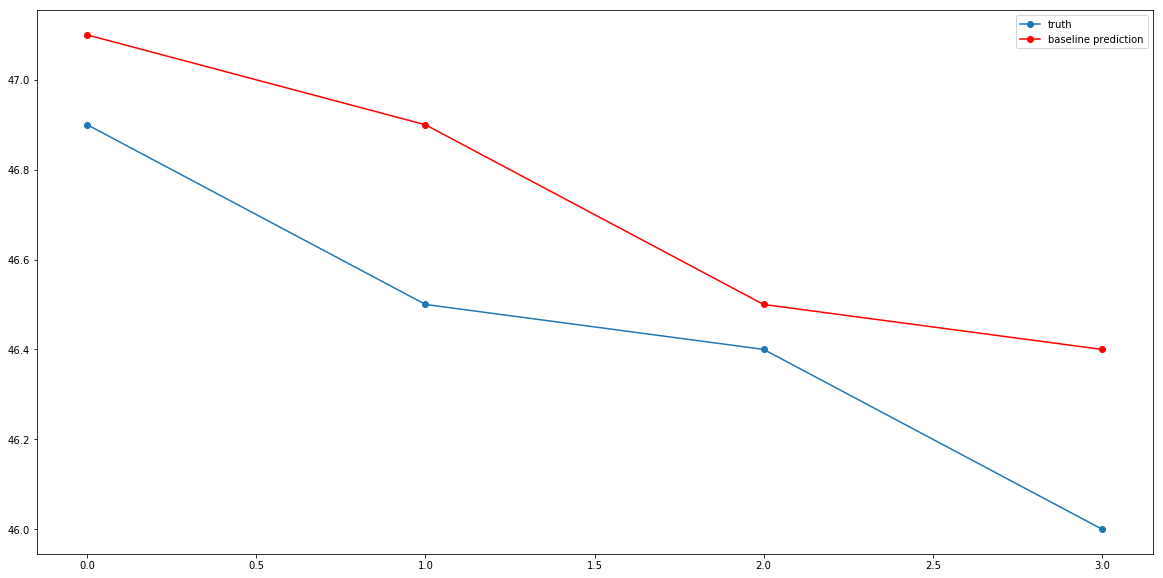

MSE: 0.0925


In [78]:
from sklearn.metrics import mean_squared_error

# use only the columns we care about
df_ft = pd.DataFrame(df[df['nature_of_employment'] == 'full-time'],
                     columns=['total_paid_hours'])

train, test = create_train_test(df_ft, '2012')

print("\nTrain dataset:\n", train.head(5))
print("\nTest dataset:\n", test.head(5))

# walk-forward validation using baseline model: f(x) = x
baseline_predictions = [baseline_model(x) for x in test['t']]
print("\nPredictions:\n", baseline_predictions)

# plot the predictions vs truth
_, ax = plt.subplots(figsize=(20,10))
f1, = ax.plot(test['t+1'].values, marker='o')
f2, = ax.plot(baseline_predictions, color='red', marker='o')
ax.legend([f1, f2], ['truth', 'baseline prediction'])
plt.show()

score = mean_squared_error(test['t+1'], baseline_predictions)
print("MSE:", score)

## LSTM RNN

Now we are ready to train our RNN to see if it can beat the baseline model.

We will keep the architecture simple and create a single-layer LSTM that feeds into a fully-connected (Dense) layer.

```
model = Sequential()
model.add(LSTM(...))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
```

Note: As an exercise, you are encouraged to try the Statistical models as well.

## RNN: preparing data

### Convert Time Series to Supervised dataset
Unlike statistical models, RNN is a supervised learning problem. This means that we'll need to convert 
the data from a time series $(t, X)$ to a supervised learning dataset $(x, y)$.  

Because the baseline model is also a supervised learning problem, we aleady have the code for doing this in `create_train_test`.

### Scaling
LSTMs use `tanh` activations, so we will need to scale the data to -1 and 1.

We'll use the training dataset to scale the data, so that there is no contamination from the test dataset.

In [80]:
# use only the columns we care about
df_ft = pd.DataFrame(df[df['nature_of_employment'] == 'full-time'],
                     columns=['total_paid_hours'])

train, test = create_train_test(df_ft, '2012')